# **Collaborative Filtering Recommender System using Random Walks and Music Genre Hierarchy based Method**

**Student:** Caio Eduardo Ramos Arães

**Supervisor:** Gabriel Barbosa da Fonseca

**Subject:** TCC I

# References

1. Kaggle (2017). **Dataset for collaborative filters**. Acesso em: 11 abril 2024.
2. Yahoo (2002-2006). **R2 - yahoo! music user ratings of songs with artist, album, and genre meta information, v. 1.0**. Base de Dados.

# Python libraries

In [ ]:
import requests
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# Importing dataset

In [ ]:
file_url = 'https://drive.google.com/uc?export=download&id=1GhD89UOUJMmI3uSa_NG7ZKuPsqUdLWFW'
file_path = '/content/sample_data/kaggle_CF_dataset.csv'

In [ ]:
response = requests.get(file_url)

if response.status_code == 200:
  with open(file_path, 'wb') as file:
    file.write(response.content)
    print("File downloaded with success!")
else:
    print("Failed to download the file.")

with open(file_path, 'r', encoding='utf-8') as file:
  file = file.read()

File downloaded with success!


In [ ]:
df = pd.read_csv(file_path, nrows=1000, quotechar="'")

interaction_matrix = df.pivot(index='userID', columns='songID', values='rating').fillna(0)

# Measuring similarity between users (cossine similarity)

In [ ]:
user_similarities = cosine_similarity(interaction_matrix)
user_ids = interaction_matrix.index
user_sim_matrix = pd.DataFrame(user_similarities, index=user_ids, columns=user_ids)

# Building user-music graph

In [ ]:
G = nx.Graph()

user_nodes = set()
song_nodes = set()

# Adicionar arestas entre usuários e músicas baseado na nota
for row in df.itertuples():
    user_id = f"user_{row.userID}"
    song_id = f"song_{row.songID}"
    rating = row.rating

    user_nodes.add(user_id)
    song_nodes.add(song_id)

    G.add_edge(user_id, song_id, weight=rating, type='user-song')

# Adicionar arestas entre usuários baseado na similaridade do cosseno
for i in range(len(user_ids)):
    for j in range(i + 1, len(user_ids)):
        user_id1 = f"user_{user_ids[i]}"
        user_id2 = f"user_{user_ids[j]}"
        similarity = user_sim_matrix.iloc[i, j]

        if similarity > 0:  # Adicionar aresta apenas se houver similaridade positiva
            G.add_edge(user_id1, user_id2, weight=10*similarity, type='user-user')

In [ ]:
# Subgrafo com arestas apenas entre usuários e músicas
G_user_song = G.edge_subgraph([(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'user-song'])

# Subgrafo com arestas apenas entre usuários
G_user_user = G.edge_subgraph([(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'user-user']).copy()
G_user_user.add_nodes_from([f"user_{user_id}" for user_id in user_ids])

# Graph visualization

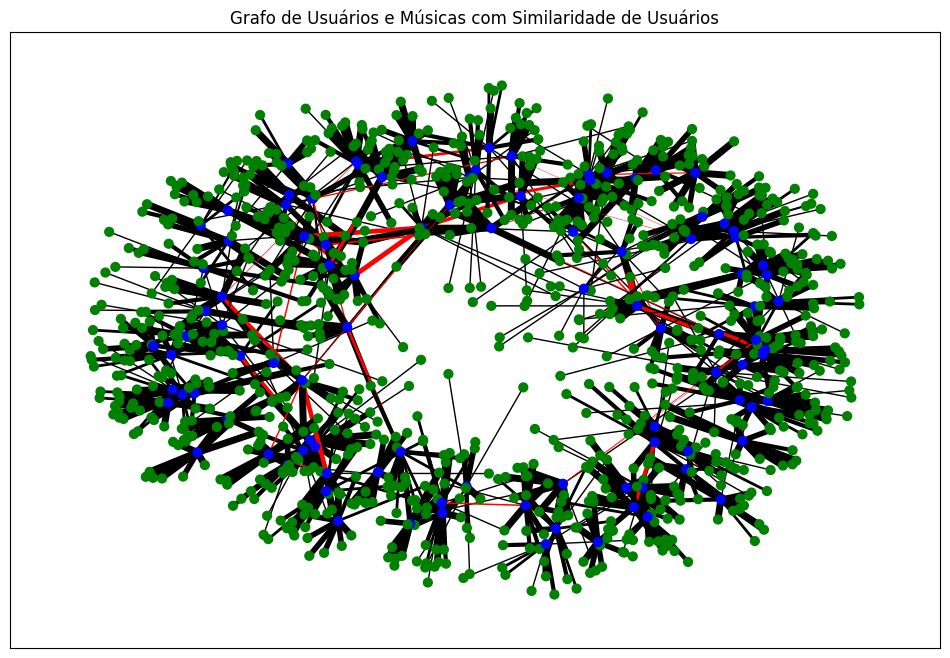

In [ ]:
node_colors = []
for node in G.nodes():
    if node in user_nodes:
        node_colors.append('blue')  # cor para usuários
    else:
        node_colors.append('green') # cor para músicas

edge_colors = ['red' if G[u][v]['type'] == 'user-user' else 'black' for u, v in G.edges()]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15) # escolha do layout
edges = G.edges(data=True)
weights = [float(edge[2]['weight']) for edge in edges if 'weight' in edge[2]] # a grossura da aresta reflete o valor do peso da relação entre nós

nx.draw_networkx_nodes(G, pos, node_size=40, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color=edge_colors)
#nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title('Grafo de Usuários e Músicas com Similaridade de Usuários')
plt.show()

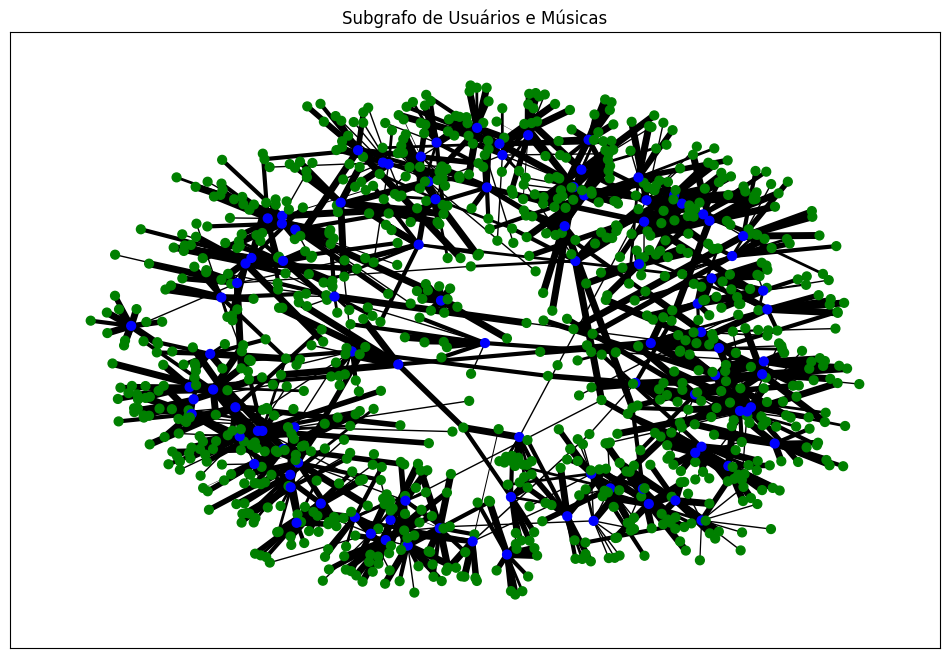

In [ ]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_user_song, k=0.15)

edge_colors = ['black' for u, v in G_user_song.edges()]

nx.draw_networkx_nodes(G_user_song, pos, node_size=40, node_color=node_colors)
nx.draw_networkx_edges(G_user_song, pos, edgelist=G_user_song.edges(), width=weights, edge_color=edge_colors)
#nx.draw_networkx_labels(G_user_song, pos, font_size=10, font_family='sans-serif')

plt.title('Subgrafo de Usuários e Músicas')
plt.show()

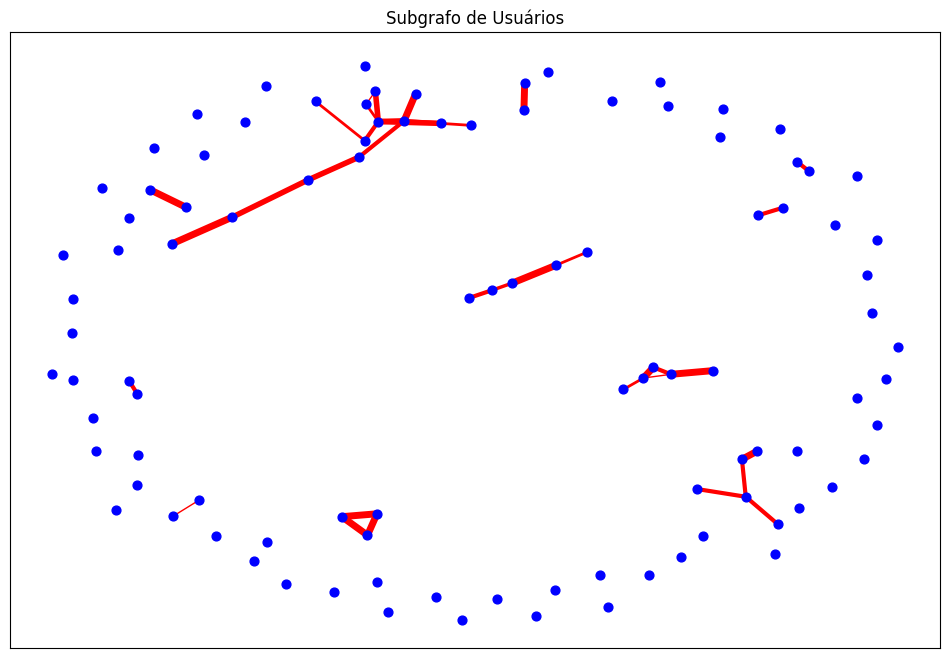

In [ ]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_user_user, k=0.15)

edge_colors = ['red' for u, v in G_user_user.edges()]

nx.draw_networkx_nodes(G_user_user, pos, node_size=40, node_color='blue')
nx.draw_networkx_edges(G_user_user, pos, edgelist=G_user_user.edges(), width=10*weights, edge_color=edge_colors)
#nx.draw_networkx_labels(G_user_user, pos, font_size=9, font_family='sans-serif')

plt.title('Subgrafo de Usuários')
plt.show()

# Random Walks

In [ ]:
def random_walk(graph, start_node, walk_length):
    walk = [start_node]
    for _ in range(walk_length - 1):
        neighbors = list(graph.neighbors(walk[-1]))
        if len(neighbors) == 0:
            break
        walk.append(random.choice(neighbors))
    return walk

def recommend_songs(graph, user_id, num_recommendations, walk_length=10, num_walks=100):
    song_counts = defaultdict(int)
    for _ in range(num_walks):
        walk = random_walk(graph, user_id, walk_length)
        for node in walk:
            if node in song_nodes and node not in G.neighbors(user_id):
                song_counts[node] += 1
    recommended_songs = sorted(song_counts.items(), key=lambda item: item[1], reverse=True)
    return recommended_songs[:num_recommendations]

In [ ]:
user_id = 'user_1'  # substitua pelo ID de usuário desejado, lembre-se de prefixar com 'user_'
num_recommendations = 5
recommendations = recommend_songs(G, user_id, num_recommendations)

print(f'Recomendações de músicas para o usuário {user_id}:')
for song, count in recommendations:
    print(f"{song} ({count} vezes)")

Recomendações de músicas para o usuário user_1:
song_1826 (12 vezes)
song_83489 (12 vezes)
song_72693 (10 vezes)
song_82804 (9 vezes)
song_130700 (9 vezes)
